# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, cross_validate
from lightgbm import LGBMRegressor

# Loading Data

In [2]:
# Loading data
train = pd.read_csv('data/train.csv')
policies = pd.read_csv('data/policies.csv')
test = pd.read_csv('data/test.csv')
samplesubmission = pd.read_csv('data/SampleSubmission.csv')

# Preview train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.0,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.0,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.0,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.0,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.0,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64


# Feature Engineering

In [4]:
# casting
def build_features(df):
    # Time features
    df['loss_date'] = pd.to_datetime(df['loss_date'])
    df['loss_date_day'] = df.loss_date.dt.day
    df['loss_date_month'] = df.loss_date.dt.month
    df['loss_date_year'] = df.loss_date.dt.year
    # log of insured sum
    df['log_sum'] = np.log1p(df['sum_insured'])
    return df

In [7]:
train_df = build_features(train)
test_df = build_features(test)

In [8]:
# Apply log(1+y) to avoid large values on target
train_df['target'] = np.log1p(train.target)

In [9]:
# Convert object to 'category'
# Convert categorical variables to categorical objects
cat_cols = train_df.columns.difference(['claim_id', 'loss_date','sum_insured','log_sum', 'target']).tolist()
for col in cat_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [11]:
cols_to_drop = ['loss_date']
train_df = train_df.drop(cols_to_drop,axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

# CV Code

In [12]:
from sklearn.model_selection import KFold
def evaluate(model,args,train,k=5):
    y = train.target
    y = pd.Series(y)
    X = train.drop(['claim_id','target'],axis='columns')
    kf = KFold(n_splits=k)
    scores = []
    for train_index, test_index in kf.split(X):
        m = model(**args) 
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        m.fit(X_train,y_train)
        y_hat = m.predict(X_test)
        score = mae(np.expm1(y_test),np.expm1(y_hat))
        
        print(score)
        scores.append(score)
    print('MAE Average on ',k,' folds: ', sum(scores)/k)
    print('MAE std on ',k,' folds: ', np.std(scores)) 

In [47]:

params = {
    'objective': 'mae',
    'n_estimators':200,
    'max_depth':7,
    'num_leaves':15,
    'learning_rate':0.2
}
evaluate(LGBMRegressor,params,train_df,10)

37235.440912263184
33638.02674775547
28496.718093654472
46728.2915860278
37796.162209915106
28251.256265642052
31167.673506247418
27278.062646977745
51231.0249582277
28896.38214440405
MAE Average on  10  folds:  35071.9039071115
MAE std on  10  folds:  7842.355479257708


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances-01.png')
    plt.show()

# Fitting & Predictions

In [36]:

X = train_df.drop(['claim_id','target'],axis=1)
y = train_df.target

In [37]:
print(params)
model = LGBMRegressor(**params)
model.fit(X,y)

{'objective': 'mae', 'n_estimators': 300, 'max_depth': 7, 'num_leaves': 15, 'learning_rate': 0.05}


LGBMRegressor(learning_rate=0.05, max_depth=7, n_estimators=300, num_leaves=15,
              objective='mae')

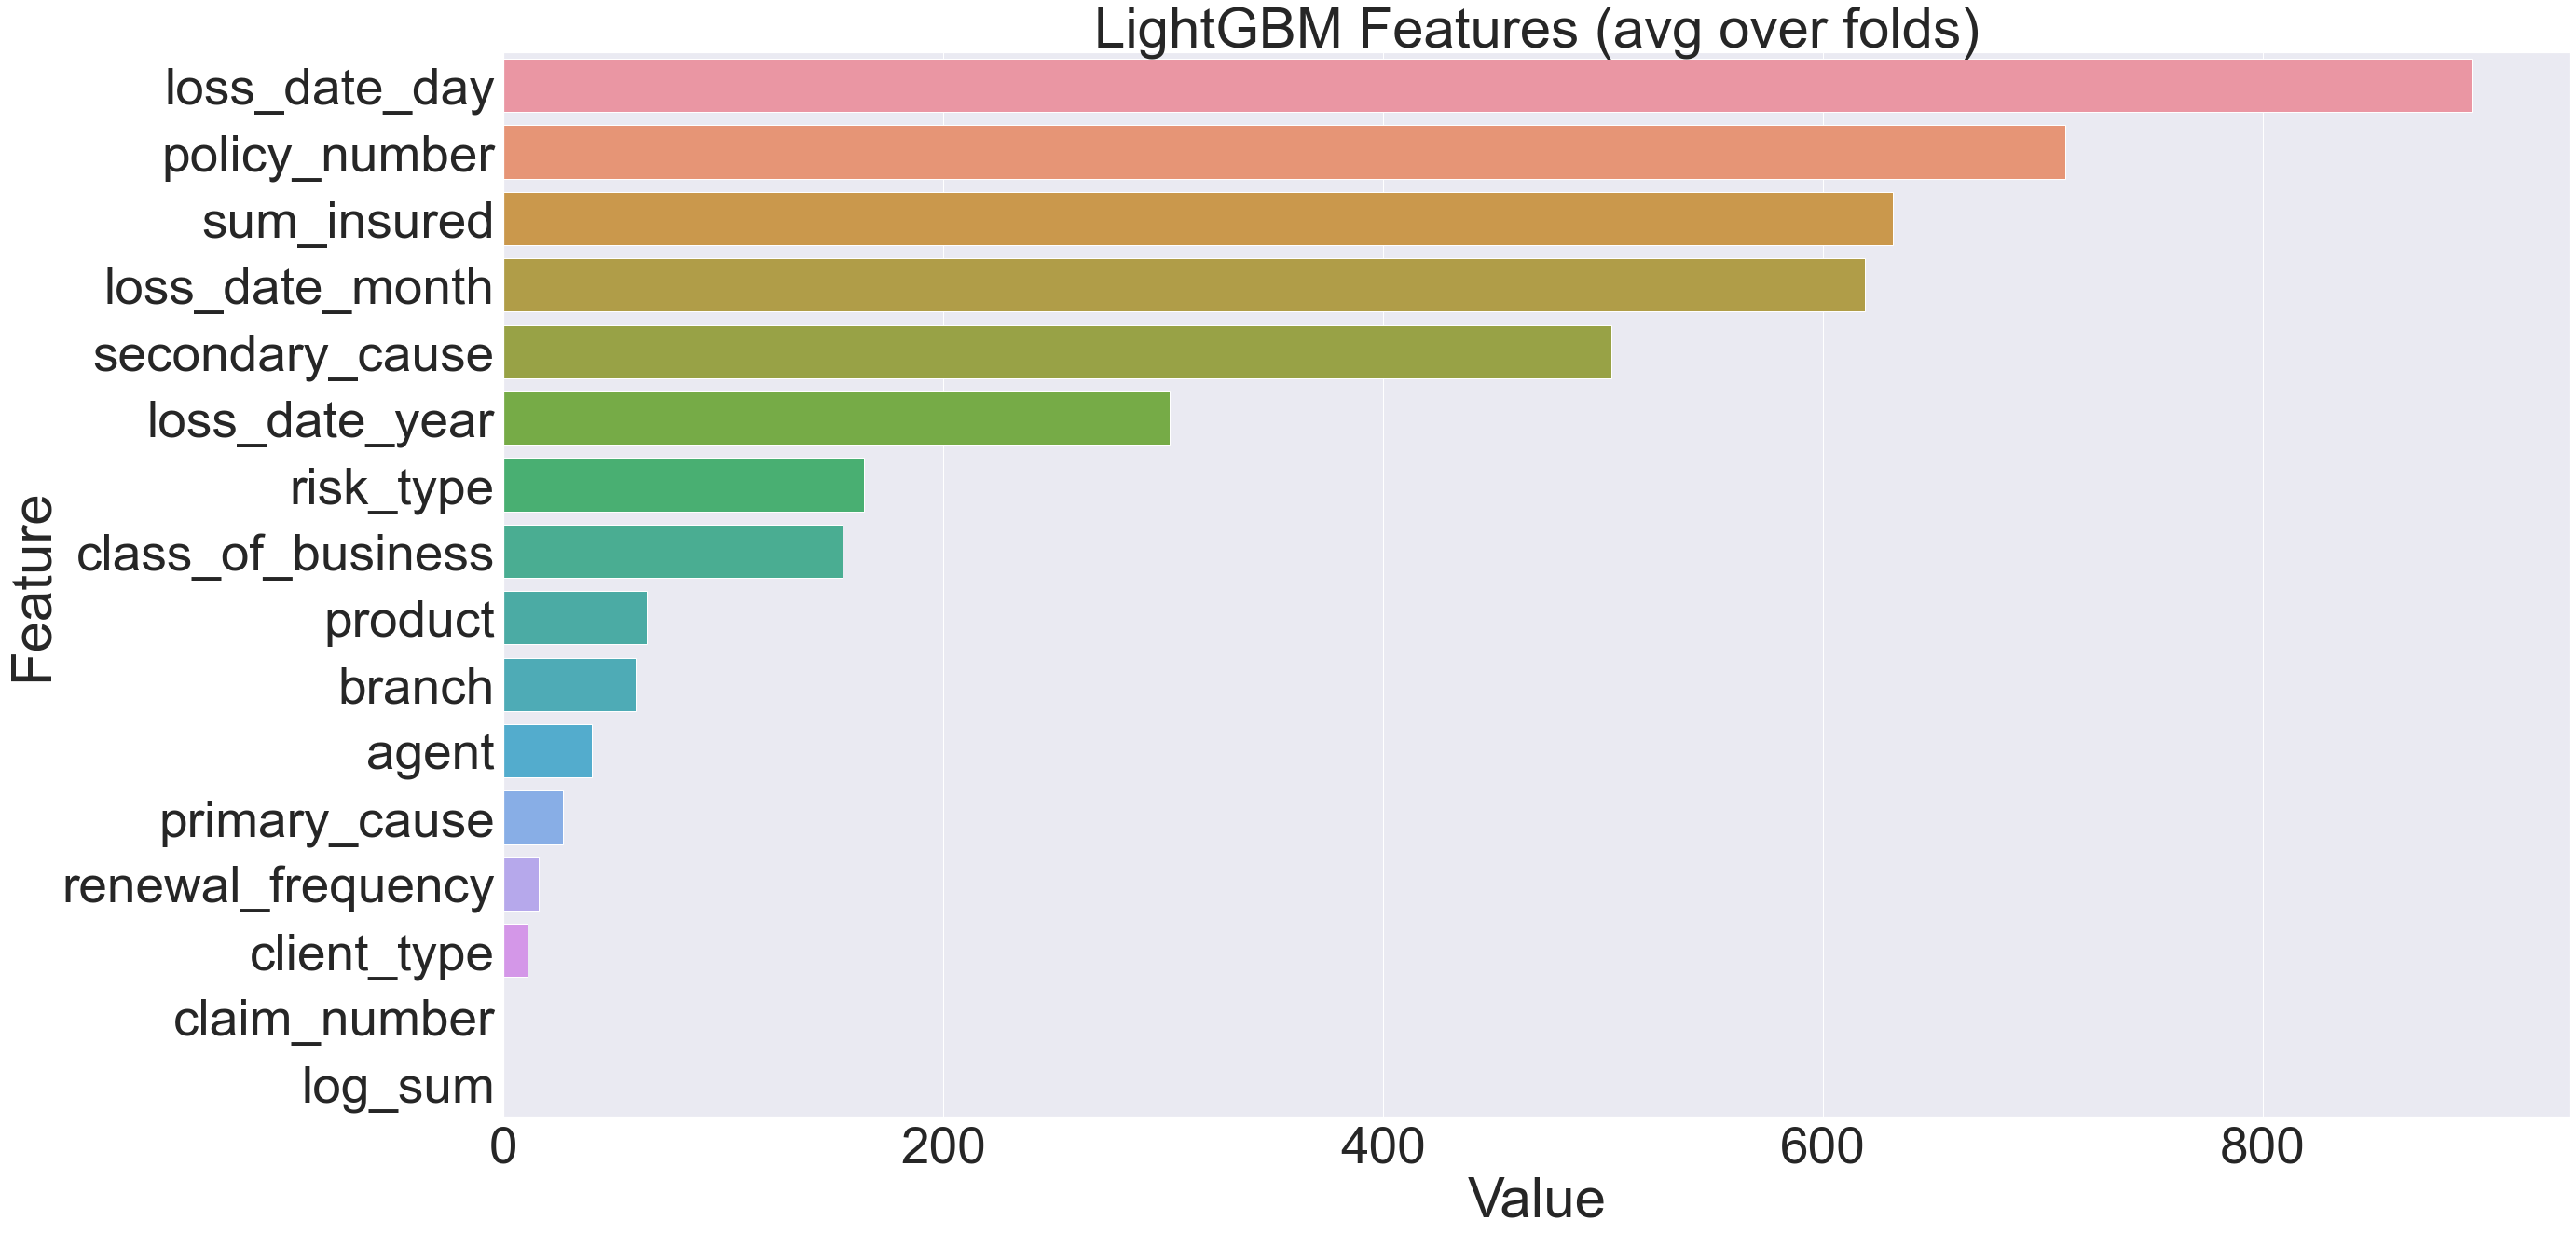

In [38]:
plotImp(model,X,20)

In [23]:
params

{'objective': 'mae',
 'n_estimators': 200,
 'max_depth': 7,
 'num_leaves': 16,
 'learning_rate': 0.2}

In [39]:
predictions = model.predict(test_df.drop(['claim_id'],axis=1))
# Don't forget to inverse the transformation
preds = np.expm1(predictions)

In [25]:
preds

array([134343.72117303,  29708.58836989,   5061.27135423, ...,
       100660.35080103,  45003.7676749 ,  70698.02595782])

In [40]:
sub = samplesubmission.copy()
sub.target = preds
sub.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,131631.447234
1,ID_GTE9ZUJ9GZ97,33189.069758
2,ID_RUVIYRKWZ4RG,4092.023008
3,ID_J81X8SWU6JYN,1771.013336
4,ID_94NM3JJAWWOQ,9093.823302


In [41]:
sub.target.describe()


count      4019.000000
mean      14421.348552
std       35272.641297
min          38.298599
25%         852.878499
50%        1889.469522
75%       10140.805561
max      795673.810324
Name: target, dtype: float64

In [42]:
train_df.target.describe()

count    9376.000000
mean        7.108465
std         3.518393
min         0.000000
25%         5.666167
50%         7.579640
75%         9.449486
max        15.878390
Name: target, dtype: float64

In [43]:
# Write to csv file to submit to Zindi
sub_fn = 'winning_lgbm_mae_2.csv'
sub.to_csv(f"submissions/{sub_fn}", index = False)